In [115]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import itertools


### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия

In [4]:
df = pd.read_csv('churn_data.csv', index_col='RowNumber')
df.head()
# Отток клиентов банка

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
df.shape

(10000, 13)

In [11]:
df.Surname.nunique()
# можно объяснить такое относительное небольшое кол-во фамилий тем, что это могут быть одни семьи, просто совпадениями 
# или у одного человека есть счета в разных странах. 

2932

In [12]:
df.Geography.nunique()
#можно использовать dummies

3

In [13]:
df.Gender.nunique()
#пропусков нет

2

In [7]:
df.columns.to_list()

['CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [14]:
cols = ['CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Exited'], random_state=0)

In [38]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

In [78]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [79]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [80]:
from sklearn.pipeline import FeatureUnion
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [81]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [82]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [83]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [84]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [85]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC


In [86]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

metrics_df = metrics_df.append({
    'model': pipeline.get_params(deep=False)['steps'][1][1],
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc_score(y_test, preds)
}, ignore_index=True)
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,"(DecisionTreeClassifier(max_features='auto', r...",0.38,0.640641,0.653061,0.628684,0.863502


In [54]:
from catboost import CatBoostClassifier

In [87]:
categorical_columns = ['Surname','Geography', 'Gender']

In [88]:
ctb = CatBoostClassifier(iterations=100, thread_count=10, random_state=42, silent=True)
ctb.fit(X_train, y_train, 
        cat_features=categorical_columns, 
        verbose=False
)


In [89]:
preds = ctb.predict_proba(X_test)[:, 1]

In [90]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

metrics_df = metrics_df.append({
    'model': 'CatBoost',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc_score(y_test, preds)
}, ignore_index=True)
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,"(DecisionTreeClassifier(max_features='auto', r...",0.380000,0.640641,0.653061,0.628684,0.863502
1,CatBoost,0.340422,0.647454,0.633459,0.662083,0.874779


In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [92]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [93]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
        ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [95]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [96]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [97]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [112]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

metrics_df = metrics_df.append({
    'model': pipeline.get_params(deep=False)['steps'][1][1],
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc_score(y_test, preds)
}, ignore_index=True)


In [113]:
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,"(DecisionTreeClassifier(max_features='auto', r...",0.380000,0.640641,0.653061,0.628684,0.863502
1,CatBoost,0.340422,0.647454,0.633459,0.662083,0.874779
2,LogisticRegression(random_state=42),0.289522,0.509700,0.462400,0.567780,0.772077


### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на удержание, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Была выбрана модель CatBoost, так как у нее выше F-score и recall. 

Чтобы понять какая метрика наиболее подходящая и одновременно ответить на третий вопрос, я сделал 3 матрицы, в которых были максимизирвоаны F-score, recall и precision. 

Для расчета экономической обоснованности я буду использовать следующую формулу: 2 * (tp-fp) - (fn+tn), так как 2 доллара нам будут давать наши существующие клиенты(tp) минус ушедшие клиенты(fp), так как мы не смогли идентифицировать их как уходящих и соответственно не удержали их. Из них мы вычтем и тех, клиентов, которые ушли в отток(tn), так как мы их правильно нашли и потратим деньги на их удержание, но так же мы потратим деньги на удержание неправильно идентифицированных клиентов(fn).



In [122]:
print(f'f_score: {2*(1796-195)-(173+336)}')
print(f'recall: {2*(58-1993)-(508+1)}')
print(f'precision: {2*(1991)-(477+32)}')

f_score: 2693
recall: -4379
precision: 3473


### В итоге мы видим, что лучшей метрикой конкретно в этой задаче, оказалась precision, так как при нашем соотношении оттока 1 к 4, нам лучше просто определить всех как "не уходящих"  и не тратить деньги на удержание кого-либо. 

In [117]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1796  195]
 [ 173  336]]


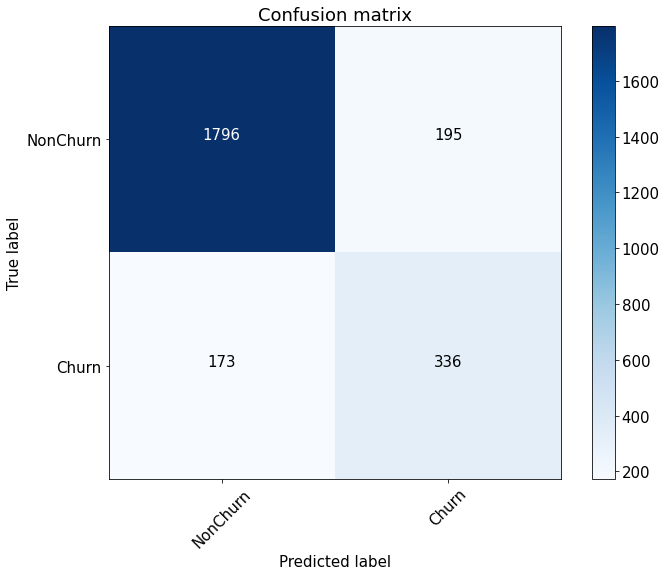

In [118]:
categorical_columns = ['Surname','Geography', 'Gender']
ctb = CatBoostClassifier(iterations=100, thread_count=10, random_state=42, silent=True)
ctb.fit(X_train, y_train, 
        cat_features=categorical_columns, 
        verbose=False
)
preds = ctb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[  58 1933]
 [   1  508]]


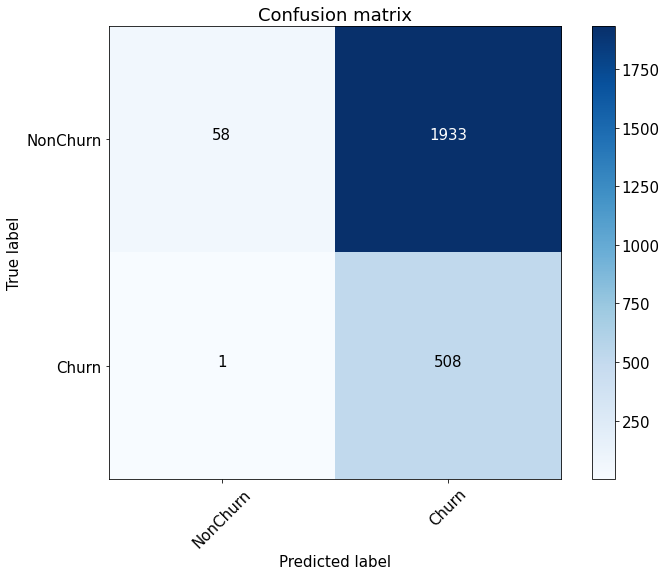

In [119]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(recall)
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1991    0]
 [ 477   32]]


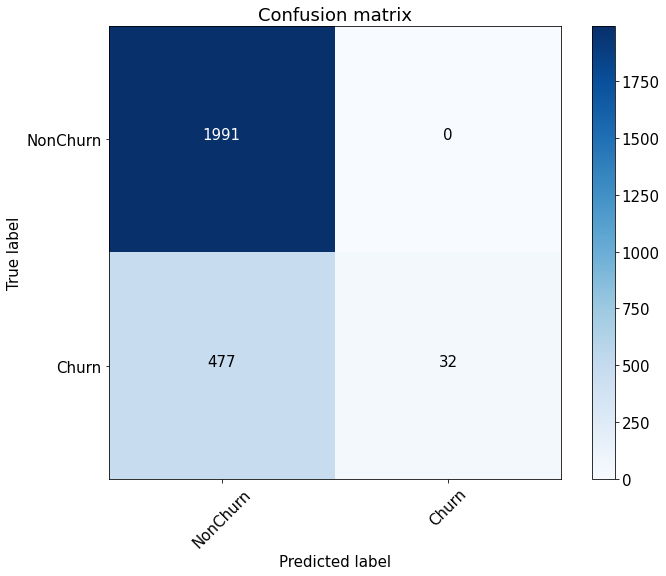

In [120]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(precision)
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [150]:
from sklearn.model_selection import GridSearchCV
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
model = CatBoostClassifier(cat_features=categorical_columns, task_type="GPU", verbose=1000)

In [151]:
grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train)

0:	learn: 0.6811287	test: 0.6808267	best: 0.6808267 (0)	total: 35.9ms	remaining: 35.9s
999:	learn: 0.3341854	test: 0.3190020	best: 0.3189995 (988)	total: 35.6s	remaining: 0us
bestTest = 0.318999471
bestIteration = 988
0:	loss: 0.3189995	best: 0.3189995 (0)	total: 36.7s	remaining: 17m 43s
0:	learn: 0.6547353	test: 0.6538086	best: 0.6538086 (0)	total: 28.9ms	remaining: 28.9s
999:	learn: 0.3048864	test: 0.3086727	best: 0.3048160 (528)	total: 33.6s	remaining: 0us
bestTest = 0.30481604
bestIteration = 528
1:	loss: 0.3048160	best: 0.3048160 (1)	total: 1m 10s	remaining: 16m 33s
0:	learn: 0.6811390	test: 0.6808267	best: 0.6808267 (0)	total: 32.1ms	remaining: 32.1s
999:	learn: 0.3334491	test: 0.3161292	best: 0.3161172 (955)	total: 35.3s	remaining: 0us
bestTest = 0.3161172282
bestIteration = 955
2:	loss: 0.3161172	best: 0.3048160 (1)	total: 1m 46s	remaining: 16m 1s
0:	learn: 0.6547658	test: 0.6538086	best: 0.6538086 (0)	total: 32ms	remaining: 31.9s
999:	learn: 0.3026498	test: 0.3069226	best: 0.3

999:	learn: 0.3309874	test: 0.3138092	best: 0.3137312 (964)	total: 42.5s	remaining: 0us
bestTest = 0.3137312215
bestIteration = 964
28:	loss: 0.3137312	best: 0.3034435 (5)	total: 17m 33s	remaining: 36.3s
0:	learn: 0.6548975	test: 0.6557022	best: 0.6557022 (0)	total: 27.2ms	remaining: 27.2s
999:	learn: 0.3061620	test: 0.3068987	best: 0.3068987 (999)	total: 36.5s	remaining: 0us
bestTest = 0.3068987223
bestIteration = 999
29:	loss: 0.3068987	best: 0.3034435 (5)	total: 18m 10s	remaining: 0us
Estimating final quality...
0:	learn: 0.6547793	test: 0.6544917	best: 0.6544917 (0)	total: 1.79s	remaining: 29m 52s
999:	learn: 0.3142490	test: 0.3380174	best: 0.3378726 (931)	total: 30m 37s	remaining: 0us


In [146]:
grid_search_result['params'] #cpu

{'depth': 4, 'l2_leaf_reg': 7, 'learning_rate': 0.1}

In [152]:
grid_search_result['params'] #gpu

{'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

### 5. (опционально) Еще раз провести оценку экономической эффективности

Confusion matrix, without normalization
[[1809  182]
 [ 186  323]]


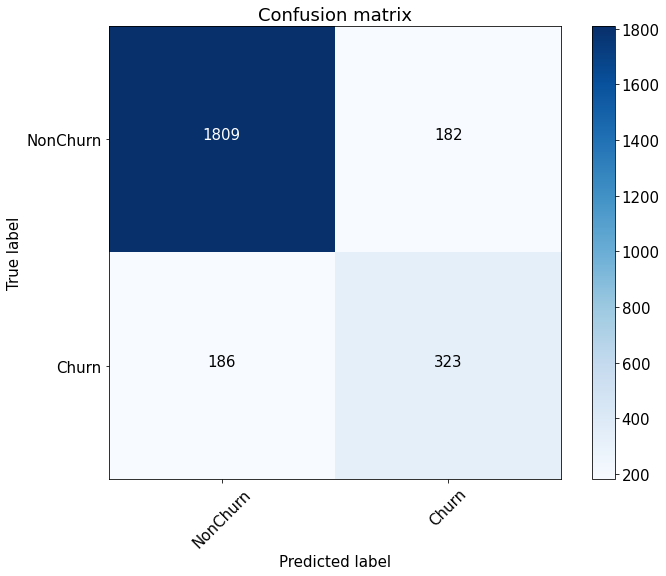

In [155]:
preds = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()


Confusion matrix, without normalization
[[1991    0]
 [ 481   28]]


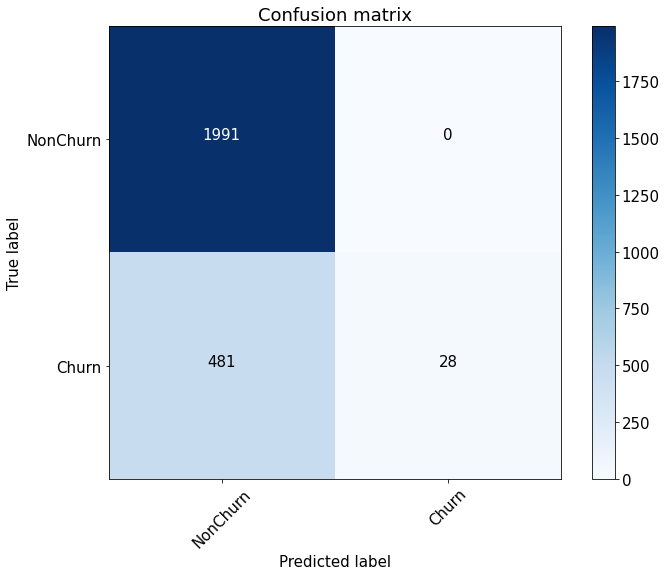

In [157]:
preds = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(precision)
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()


In [159]:
print(f'New model f-score: {2*(1802-182)-(186+323)} previous results: 2693')
print(f'New model recall: {2*(1991)-(481+28)} previous result: 3473')

New model f-score: 2731 previous results: 2693
New model recall: 3473 previous result: 3473
